# DEA CoastLines validation

To do:
* [X] Change output CRS to Australian Albers
* [X] Discard validation sides with multiple intersects?
* [X] Split analysis code into:
    * Aggregate multiple profiles and export into single file
    * Analyse and plot single file
* [ ] Add extraction of environmental data for each profile line

## Load modules/functions


In [3]:
%matplotlib inline
%load_ext line_profiler
%load_ext autoreload
%autoreload 2

import sys
import glob
import numpy as np
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import box

sys.path.append('/g/data/r78/rt1527/dea-notebooks/DEACoastLines/')
import deacoastlines_validation as deacl_val
import deacoastlines_statistics as deacl_stats

def to_vector(df, fname='test.shp', x='x', y='y', crs='EPSG:3577', output_crs='EPSG:3577'):
    
    # Convert datetimes to strings
    df = df.copy()
    is_datetime = df.dtypes == 'datetime64[ns]'
    df.loc[:, is_datetime] = df.loc[:, is_datetime].astype(str) 
    
    # Export to file
    gdf = gpd.GeoDataFrame(data=df.loc[:, df.dtypes != 'datetime64[ns]'],
                     geometry=gpd.points_from_xy(x=df[x], y=df[y]),
                     crs=crs).to_crs(output_crs).to_file(fname)
    
    return gdf


def export_eval(df, output_name, output_crs='EPSG:3577'):
    
    from shapely.geometry import box, Point, LineString

    # Extract geometries
    val_points = gpd.points_from_xy(x=df.val_x, y=df.val_y)
    deacl_points = gpd.points_from_xy(x=df.deacl_x, y=df.deacl_y)
    df_profiles = df.groupby('id').first()
    profile_lines = df_profiles.apply(
        lambda x: LineString([(x.start_x, x.start_y), (x.end_x, x.end_y)]), axis=1)

    # Export validation points
    val_gdf = gpd.GeoDataFrame(data=df,
                               geometry=val_points,
                               crs=output_crs).to_crs('EPSG:4326')
    val_gdf.to_file(f'figures/eval/{output_name}_val.geojson', driver='GeoJSON')

    # Export DEACL points
    deacl_gdf = gpd.GeoDataFrame(data=df,
                                 geometry=deacl_points,
                                 crs=output_crs).to_crs('EPSG:4326')
    deacl_gdf.to_file(f'figures/eval/{output_name}_deacl.geojson', driver='GeoJSON')

    # Export profiles
    profile_gdf = gpd.GeoDataFrame(data=df_profiles,
                                 geometry=profile_lines,
                                 crs=output_crs).to_crs('EPSG:4326')
    profile_gdf.to_file(f'figures/eval/{output_name}_profiles.geojson', driver='GeoJSON')
    

## Analysis
To investigate:
* [X] Outlier in Bermagui (Horseshoe Bay)
* [X] **Multiple outliers in Boambee Beach**
* [X] Single remaining outlier in Bogangar to Kingscliff
* [X] **Cluster of outliers in Burgess Beach: caused by one year of channel profiles**
* [X] Sporadic outliers in Byron Bay
* [X] Two remaining outlier in Corindi Beach
* [X] **Major outliers at Crowdy Head**
* [X] **String of outliers in opposite direction at Cullendulla**
* [X] One remaining outlier at Diamond Beach
* [X] One remaining outlier at Eurobadalla Beaches North
* [ ] **Cluster of outliers at Evans Head and Broadwater**
* [X] Two outliers in Fern Bay
* [ ] **Extreme outliers at Flynn's Beach**
* [ ] **Skewed result at Gerringong Harbour**
* [ ] Outliers in Hargrave's Beach
* [ ] Remaining outliers at Jimmy's Beach
* [X] **Remaining major outlier at Lake Illawarra**
* [X] **Outliers in Manly Beach**
* [X] **Outliers at Mooney Beach**
* [X] **Major issues with offset shorelines at Narrabeen/Collory**
* [X] Outlier at Ocean View Beach
* [X] **Outliers in opposite direction at Park's Beach**
* [X] Cluster of outliers at Patch's Beach
* [X] Outliers at Port Hacking 
* [X] **Weird line of points at Rainbow Beach**
* [X] **No relationship at Sandbar Beach**
* [ ] Outliers at Shellharbour Little Lake
* [X] One remaining outlier at Stuart's Point
* [ ] **Several remaining outliers at Swansea Belmont**
* [X] **Cluster of outliers at The Entrance**
* [X] Single outlier at Warrain
* [ ] **Major issues with Valla Beach**

In [171]:
val_paths = glob.glob('output_data/cgc_*.csv')
deacl_path = '../packages/DEACoastLines_v0.2.0/DEACoastLines_coastlines_v0.2.0.shp'
# deacl_path = '../DEACoastLines_coastlines_v0.2.0_0.20.shp'

stats_list = []

for val_path in val_paths:
    
    # Run analysis and close resulting figure
    print(f'{val_path:<80}', end='\r')
    output_stats = deacl_val.deacl_validation(val_path, 
                                              deacl_path,
                                              datum=0)
    
    # Append stats to list
    stats_list.append(output_stats)
    
# Combine stats into a dataframe
stats_df = pd.concat(stats_list)
stats_df.head()


,id,year,beach,section,profile,source,certainty,n,start_x,start_y,end_x,end_y,val_x,val_y,val_dist,deacl_x,deacl_y,deacl_dist,diff_dist
0,fingal_eta_10,1988,fingal,eta,8,hydrographic survey,good,1,2.081241e+06,-3.234552e+06,2.081527e+06,-3.234486e+06,2.081333e+06,-3.234531e+06,94.494323,2.081314e+06,-3.234535e+06,75.009259,19.485064
2,fingal_eta_6,1988,fingal,eta,8,hydrographic survey,good,1,2.081486e+06,-3.236162e+06,2.081712e+06,-3.236109e+06,2.081541e+06,-3.236149e+06,56.940799,2.081523e+06,-3.236153e+06,38.031013,18.909786
3,fingal_eta_8,1988,fingal,eta,8,hydrographic survey,good,1,2.081369e+06,-3.235355e+06,2.081525e+06,-3.235319e+06,2.081397e+06,-3.235349e+06,28.717883,2.081388e+06,-3.235351e+06,19.710707,9.007176
4,fingal_pwd_l.179s,1988,fingal,eta,8,hydrographic survey,good,1,2.081181e+06,-3.234193e+06,2.081489e+06,-3.234203e+06,2.081370e+06,-3.234199e+06,188.842338,2.081301e+06,-3.234197e+06,119.992605,68.849733
5,fingal_pwd_l.stn1,1988,fingal,eta,8,hydrographic survey,good,1,2.081260e+06,-3.234358e+06,2.081570e+06,-3.234328e+06,2.081339e+06,-3.234350e+06,79.741738,2.081311e+06,-3.234353e+06,51.180573,28.561165


In [117]:
# Export evaluation vectord
output_name = 'cgc'
export_eval(stats_df, output_name)
# stats_df.groupby('beach').apply(lambda x: export_eval(x, x.beach.iloc[0]))

MAE: 10.24 m
RMSE: 14.23 m
StDev: 14.24
Corr: 0.955
Mean offset: 23.27 m
50th perc diff: 22.51 m


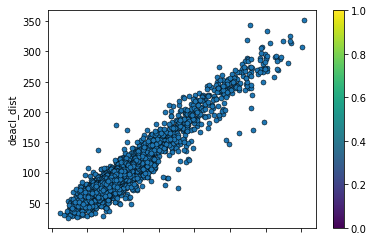

In [172]:
# Print stats and plot scatterplot
stats_subset = stats_df  #.loc[stats_df.beach=='wreckpoint']
stats_subset['deacl_dist'] += 23.31

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

def val_plot(stats_df, 
             scatter=True, 
             time=False, 
             scatter_kwargs={}, 
             time_kwargs={}):

    print(f'MAE: {mean_absolute_error(stats_df.val_dist, stats_df.deacl_dist):.2f} m\n'
          f'RMSE: {mean_squared_error(stats_df.val_dist, stats_df.deacl_dist)**0.5:.2f} m\n'
          f'StDev: {stats_df[["diff_dist"]].std().iloc[0]:.2f}\n'
          f'Corr: {stats_df[["val_dist", "deacl_dist"]].corr().iloc[0, 1]:.3f}\n'
          f'Mean offset: {stats_df[["diff_dist"]].mean().iloc[0]:.2f} m\n'
          f'50th perc diff: {stats_df["diff_dist"].abs().quantile(0.50):.2f} m')

    if scatter:
        stats_df.plot.scatter(x='val_dist',
                              y='deacl_dist',
                              s=25,
                              cmap='YlOrRd',
                              edgecolors='black',
                              linewidth=0.5,
                              **scatter_kwargs)
    
#     if time:
        

        
val_plot(stats_df=stats_subset)

In [110]:



# List of profile datasets to iterate through
profile_list = glob.glob(f'input_data/cityofgoldcoast/*.txt')

# # Output list to hold data
# site_profiles = []

# # For each profile, import and standardise data then add to list
# for profile_i in profile_list:

#     # Identify unique field values from file string
#     profile_string = os.path.basename(profile_i)

#     # Treat data file string differently depending on format
#     if len(profile_string.split(' - ')) > 3:
#         _, section, profile, id_date = profile_string.split(' - ')            

#     else:
#         _, section_profile, id_date = profile_string.split(' - ')

#         if len(section_profile.split(' ')) == 2:
#             section, profile = section_profile.split(' ')

#         else:
#             section, profile = 'all', section_profile

#             if profile == '':
#                 profile = 'a'

In [152]:
profile_string.split(' - (')[1][-14:-4]

'2001-12-12'

In [166]:
# List of profile datasets to iterate through
profile_list = glob.glob(f'input_data/cityofgoldcoast/SEAW*.txt')

# Output list to hold data
site_profiles = []

# For each profile, import and standardise data then add to list
for profile_i in profile_list:

    # Identify unique field values from file string
    profile_string = os.path.basename(profile_i)
    date = profile_string.split(' - (')[1][-14:-4]
    section_profile = profile_string.split(' - (')[0].split(' - ')[1]
    section = section_profile.split(' ')[0]
    profile = ''.join(section_profile.split(' ')[1:])
    
    # If only section exists, make this the profile
    if section and not profile:
        section, profile = 'na', section
    elif not section and not profile:
        section, profile = 'na', 'na'
        
    print(section, profile)

na na
na na
na na
na na
na na
na na
na na


In [147]:
if section and not profile:
    section, profile = 'all', section

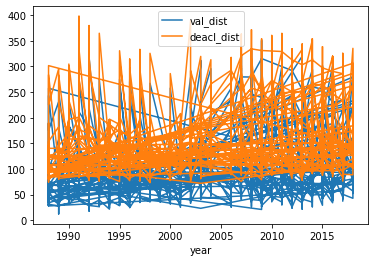

In [39]:
# stats_subset = stats_df.loc[stats_df.id=='thespit_eta_74.50'].copy()
# stats_subset['deacl_dist'] += 23
stats_subset.plot(x='year', y='val_dist')
stats_subset.plot(ax=plt.gca(), x='year', y='deacl_dist')

In [43]:
stats_subset

,id,year,beach,section,profile,source,certainty,n,start_x,start_y,end_x,end_y,val_x,val_y,val_dist,deacl_x,deacl_y,deacl_dist,diff_dist
0,fingal_eta_10,1988,fingal,eta,8,hydrographic survey,good,1,2.081241e+06,-3.234552e+06,2.081527e+06,-3.234486e+06,2.081333e+06,-3.234531e+06,94.494323,2.081314e+06,-3.234535e+06,144.939259,19.485064
2,fingal_eta_6,1988,fingal,eta,8,hydrographic survey,good,1,2.081486e+06,-3.236162e+06,2.081712e+06,-3.236109e+06,2.081541e+06,-3.236149e+06,56.940799,2.081523e+06,-3.236153e+06,107.961013,18.909786
3,fingal_eta_8,1988,fingal,eta,8,hydrographic survey,good,1,2.081369e+06,-3.235355e+06,2.081525e+06,-3.235319e+06,2.081397e+06,-3.235349e+06,28.717883,2.081388e+06,-3.235351e+06,89.640707,9.007176
4,fingal_pwd_l.179s,1988,fingal,eta,8,hydrographic survey,good,1,2.081181e+06,-3.234193e+06,2.081489e+06,-3.234203e+06,2.081370e+06,-3.234199e+06,188.842338,2.081301e+06,-3.234197e+06,189.922605,68.849733
5,fingal_pwd_l.stn1,1988,fingal,eta,8,hydrographic survey,good,1,2.081260e+06,-3.234358e+06,2.081570e+06,-3.234328e+06,2.081339e+06,-3.234350e+06,79.741738,2.081311e+06,-3.234353e+06,121.110573,28.561165
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118,miami_eta_47.50,2018,miami,eta,45,hydrographic survey,good,1,2.072509e+06,-3.220023e+06,2.072752e+06,-3.219988e+06,2.072582e+06,-3.220012e+06,73.413955,2.072567e+06,-3.220015e+06,128.778639,14.565316
119,miami_eta_47.75,2018,miami,eta,45,hydrographic survey,good,1,2.072504e+06,-3.219921e+06,2.072758e+06,-3.219884e+06,2.072580e+06,-3.219910e+06,76.387461,2.072562e+06,-3.219913e+06,128.530291,17.787170
120,miami_eta_48,2018,miami,eta,45,hydrographic survey,good,2,2.072502e+06,-3.219819e+06,2.072753e+06,-3.219782e+06,2.072580e+06,-3.219807e+06,79.331606,2.072563e+06,-3.219810e+06,132.078796,17.182810
121,miami_eta_48.25,2018,miami,eta,45,hydrographic survey,good,1,2.072496e+06,-3.219717e+06,2.072729e+06,-3.219683e+06,2.072581e+06,-3.219705e+06,86.672328,2.072560e+06,-3.219708e+06,135.138724,21.463604


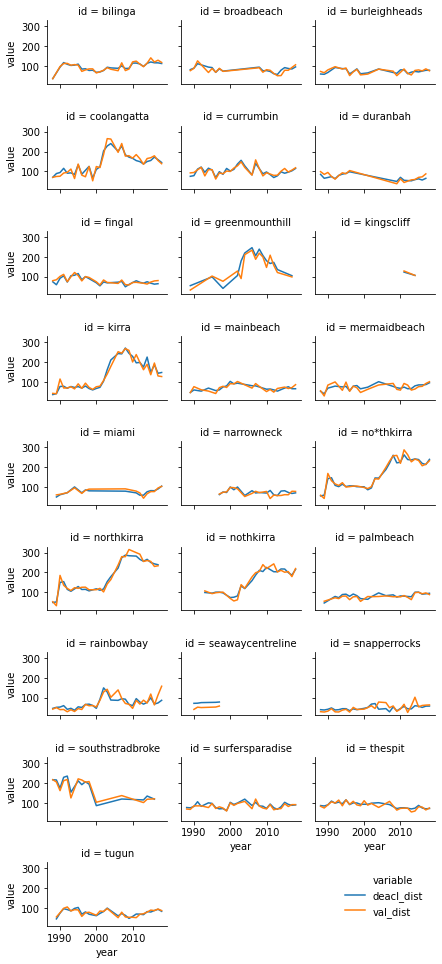

In [94]:
# import seaborn as sns
# stats_median = stats_df.groupby(['beach', 'year'], as_index=False).median()
# stats_median = stats_median.rename({'beach': 'id'}, axis=1)
# stats_median['deacl_dist'] += 23

# stats_median = stats_median.groupby('id').filter(lambda x: len(x) > 1)

# stats_melted = pd.melt(stats_median, 
#         id_vars=['id', 'year'],
#         value_vars=['deacl_dist', 'val_dist'])

g = sns.relplot(x="year", y="value", col="id", hue="variable",
            height=1.5, aspect=1.4, kind="line", legend='full', col_wrap=3,
            data=stats_melted)

leg = g._legend
leg.set_bbox_to_anchor([0.8,0.07])

g.savefig("goldcoast_beaches.jpg")

In [93]:
import pyproj
pyproj.crs.CRS('EPSG:6933').to_wkt()

'PROJCRS["WGS 84 / NSIDC EASE-Grid 2.0 Global",BASEGEOGCRS["WGS 84",DATUM["World Geodetic System 1984",ELLIPSOID["WGS 84",6378137,298.257223563,LENGTHUNIT["metre",1]]],PRIMEM["Greenwich",0,ANGLEUNIT["degree",0.0174532925199433]],ID["EPSG",4326]],CONVERSION["US NSIDC EASE-Grid 2.0 Global",METHOD["Lambert Cylindrical Equal Area",ID["EPSG",9835]],PARAMETER["Latitude of 1st standard parallel",30,ANGLEUNIT["degree",0.0174532925199433],ID["EPSG",8823]],PARAMETER["Longitude of natural origin",0,ANGLEUNIT["degree",0.0174532925199433],ID["EPSG",8802]],PARAMETER["False easting",0,LENGTHUNIT["metre",1],ID["EPSG",8806]],PARAMETER["False northing",0,LENGTHUNIT["metre",1],ID["EPSG",8807]]],CS[Cartesian,2],AXIS["easting (X)",east,ORDER[1],LENGTHUNIT["metre",1]],AXIS["northing (Y)",north,ORDER[2],LENGTHUNIT["metre",1]],USAGE[SCOPE["unknown"],AREA["World - 86°S to 86°N"],BBOX[-86,-180,86,180]],ID["EPSG",6933]]'

In [96]:
test = gpd.read_file('/g/data/r78/rt1527/dea-notebooks/DEACoastLines/validation/perth_transects.shp')

In [98]:
test['dissolve_col'] = 1
test.dissolve(by='dissolve_col')

,geometry,p1,p2
dissolve_col,,,
1,"MULTILINESTRING ((-1515354.184 -3625662.004, -...",1,0


In [99]:
test

,p1,p2,geometry,dissolve_col
0,1,0,"LINESTRING (-1515354.184 -3625662.004, -151555...",1
1,1,0,"LINESTRING (-1515280.349 -3625729.446, -151548...",1
2,1,0,"LINESTRING (-1515206.515 -3625796.888, -151540...",1
3,1,0,"LINESTRING (-1515422.263 -3625610.003, -151558...",1
4,1,0,"LINESTRING (-1515517.509 -3625560.040, -151564...",1
...,...,...,...,...
307,1,0,"LINESTRING (-1515975.167 -3614985.151, -151613...",1
308,1,0,"LINESTRING (-1516059.518 -3615038.862, -151622...",1
309,1,0,"LINESTRING (-1516143.869 -3615092.573, -151630...",1
310,0,1,"LINESTRING (-1518827.171 -3614838.280, -151852...",1


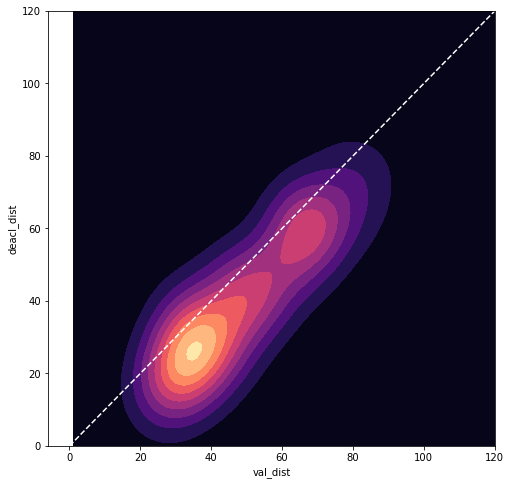

In [162]:
import seaborn as sns

extent = (0, 120)
fig, ax = plt.subplots(figsize=(8, 8))

sns.kdeplot(ax=ax,
            data=stats_df.val_dist,
            data2=stats_df.deacl_dist, 
            cmap='magma', 
            shade=True,
            clip=(extent, extent)
           )
plt.gca().plot(np.linspace(*extent), 
               np.linspace(*extent),
               color='white',
               linestyle='dashed')

In [745]:
to_vector(output_stats, fname='test6.shp', x='0_x', y='0_y', crs='EPSG:3577')

## Pre-processing


### Victoria/Deakin
* [X] Renovated

In [ ]:
deacl_val.preprocess_vicdeakin(fname='input_data/vicdeakin/z_data_10cm_VIC.csv',
                               datum=0)

### WRL Narrabeen 
* [X] Renovated

In [ ]:
deacl_val.preprocess_narrabeen(fname='input_data/wrl/Narrabeen_Profiles_2018.csv',
                               datum=0,
                               overwrite=True)


### NSW Beach Profile Database
* [X] Renovated

In [143]:
for fname in glob.glob('input_data/nswbpd/*.csv'):
    profiles_df = deacl_val.preprocess_nswbpd(fname, 
                                              datum=0, 
                                              overwrite=True)     


/g/data/v10/public/modules/dea-env/20200526/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3254: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):



Dropping invalid profiles: 19                                                                              
Processing output_data/nswbpd_brunswick.csv                                                
Dropping invalid profiles: 1                                                                               
Processing output_data/nswbpd_saphirebeach.csv                                             
Dropping invalid profiles: 13                                                                              
Processing output_data/nswbpd_ballina.csv                                                  
Dropping invalid profiles: 1                                                                               
Processing output_data/nswbpd_boambeebeach.csv                                             
Dropping invalid profiles: 9                                                                               
Processing output_data/nswbpd_saltsbay.csv                                                 

### City of Gold Coast
* [X] Renovated
* [ ] Fix North Kirra name

In [170]:
sites = ['BILINGA', 'BROADBEACH', 'BURLEIGH HEADS', 'COOLANGATTA', 'CURRUMBIN',
         'DURANABH', 'FINGAL', 'GREENMOUNT HILL', 'KINGSCLIFF', 'KIRRA',
         'MAIN BEACH', 'MERMAID BEACH', 'MIAMI', 'Main Beach Cross Sections',
         'NARROWNECK', 'NO*TH KIRRA', 'PALM BEACH', 'POINT DANGER', 
         'RAINBOW BAY', 'SEAWAY CENTRE LINE', 'SNAPPER ROCKS', 
         'SOUTH STRADBROKE', 'SURFERS PARADISE', 'THE SPIT', 'TUGUN', 
         'TWEED RIVER ENTRANCE']
sites=['SEAWAY CENTRE LINE']

for site in sites:
    profiles_df = deacl_val.preprocess_cgc(site=site,
                                           datum=0,
                                           overwrite=True)

In [100]:
# glob.glob(f'input_data/cityofgoldcoast/NO*TH KIRRA*.txt')

In [54]:
# profiles_df = profiles_df.reset_index()

In [74]:
test = profiles_df.loc[(profiles_df.id == 'palmbeach_eta_31.50') &
                (profiles_df.date.dt.year == 2008)]

In [61]:
deacl_val.waterline_intercept(test)

0_dist    4.133269e+02
0_x       2.080262e+06
0_y      -3.233222e+06
dtype: float64

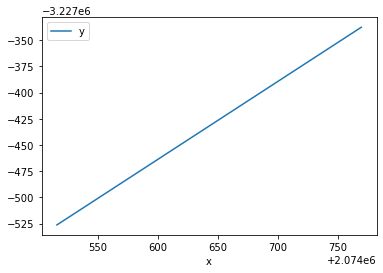

In [76]:
test.plot(x='x', y='y')

In [77]:
to_vector(test, fname='test3.shp', x='x', y='y', crs='EPSG:3577', output_crs='EPSG:3577')
    

### TASMARC
* [X] Renovated

In [ ]:
# List of sites to iterate over
sites = [i.split('/')[2] for i in glob.glob('input_data/tasmarc/*/')]

for site in sites[3:4]:
    deacl_val.preprocess_tasmarc(site, overwrite=True) 


### WA DoT
* [X] Renovated

In [554]:
# Read in tertiary compartment file to regionalise results
# tertiary_gdf = gpd.read_file('input_data/WA_tertiaryCC.shp').to_crs('EPSG:3577')
tertiary_gdf = gpd.read_file('input_data/wa_sw.geojson').to_crs('EPSG:3577')
tertiary_gdf = tertiary_gdf.set_index('FROM_')

# Extract transects and validation distances
deacl_val.preprocess_wadot(regions_gdf=tertiary_gdf, 
                           fname='input_data/wadot/Coastline_Movements_20190819.gdb',
                           smartline='../input_data/Smartline.gdb',
                           aus_poly='/g/data/r78/rt1527/shapefiles/australia/australia/cstauscd_r.shp')

### WA DoT - Stirling

In [156]:
deacl_val.preprocess_stirling(fname_out='output_data/stirling_stirling.csv',
                              datum=0)

### SA Department of Environment and Water

In [ ]:
import math
from pyproj import Transformer

# Load data and set nodata values to NaN
wide_df = pd.read_csv('input_data/sadew/200011.CSV', na_values=[-9999])

# Reproject coords to Albers and create geodataframe
trans = Transformer.from_crs("EPSG:28354", "EPSG:28356", always_xy=True)
wide_df['EASTING'], wide_df['NORTHING'] = trans.transform(
    wide_df.EASTING.values, wide_df.NORTHING.values)

# Reshape into long format with each observation on a new row
profile_df = pd.melt(wide_df.drop('SAMPLE_NO', axis=1), 
                     id_vars=['EASTING', 'NORTHING', 'PROFILE'],
                     value_name='elevation').dropna()

# Set column names to lower case
profile_df.columns = profile_df.columns.str.lower()

# Extract date info
profile_df['date'] = profile_df['variable'].str[1:].str.strip()
profile_df['date'] = pd.to_datetime(profile_df['date'], format='%d%m%Y')

# Restrict to post 1987
profile_df = profile_df[(profile_df.date.dt.year > 1987)]

# Add unique ID column
profile_df['beach'] = 'sadew'
profile_df['section'] = 'all'
profile_df['profile'] = profile_df['profile'].astype(str)
profile_df['site'] = profile_df[['beach', 'section', 'profile']].apply('_'.join, 1)
profile_df['source'] = 'sadew'

# Compute origin points for each profile
profile_df = profile_df.assign(start_x=wide_df.iloc[0, 2], 
                               start_y=wide_df.iloc[0, 3],
                               end_x=wide_df.iloc[-1, 2],
                               end_y=wide_df.iloc[-1, 3])

# Compute chainage
profile_df['chainage'] = profile_df.apply(
    lambda x: math.hypot(x.easting - x.start_x, x.northing - x.start_y), axis=1)

In [ ]:
# Find location and distance to water for datum height (0 m AHD)
out = profile_df.groupby(['site', 'date']).apply(deacl_val.waterline_intercept, 
                                                  dist_col='chainage',
                                                  x_col='easting', 
                                                  y_col='northing', 
                                                  z_col='elevation', 
                                                  z_val=0).dropna()

# If the output contains data
if len(out.index):

    # Join into dataframe
    shoreline_dist = out.join(
        profile_df.groupby(['site', 'date']).first())

    # Keep required columns
    shoreline_dist = shoreline_dist[['beach', 'section', 'profile',  
                                     'source', 'start_x', 'start_y', 
                                     'end_x', 'end_y', '0_dist', 
                                     '0_x', '0_y']]

    # Export to file
    shoreline_dist.to_csv(f'output_data/satest.csv')

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** May 2020